# Showcase notebook
In this notebook we showcase how one can calculate the distance between how a word is represented in two copera using the Earth Mover Distance / Wasserstein metric (or Word Mover Distance 

Sources: 

https://pypi.org/project/pyemd/#description #the pyemd package 

https://radimrehurek.com/gensim/auto_examples/tutorials/run_wmd.html #gensim implementation for inspiration

https://dl.acm.org/doi/10.5555/3045118.3045221 #paper reframing the EMD as the WMD for word embeddings 


Import packages

In [1]:
from pyemd import emd
import numpy as np
from scipy.spatial.distance import cdist
import ot
from tqdm.notebook import trange, tqdm
import matplotlib.pyplot as plt

Set a seed for the notebook

In [2]:
np.random.seed(10)

Define a set of word embedding vectors. Each object is an arranc of $NxD$ dimensions wher $N$ is the amount of times the word exist in the copera, and $D$ is the output size of the embeddings algorithm 

In [3]:
n1 = 100
n2 = 100

In [4]:
WordVectors1 = np.random.rand(n1,300) #creates an arrau with N observations (words/rows) and D dimensinal random embedding
WordVectors2 = np.random.rand(n2,300) 

In [5]:
#Print shape to confirm
print(WordVectors1.shape)

(100, 300)


Calculate cosine distances between each pair of word embedding. This means between each row of the data. Output is of size $N_1xN_2$

In [6]:
DistMatrix = cdist(WordVectors1,WordVectors2,metric="cosine")

Define two histogram of length $N_1 + N_2$, filled with 0's and 1's. The $N_1$ histogram, should be a vector of $N_1$ 1's followed by $N_2$ 0's. The $N_2$ histogram should be a vector of $N_1$ 0's followed by $N_2$ 1's. 

You can also see this as a kind of identity vector, showing how many times each distance appearch in each corpus (distribution) 


By setting the first histogram to all 1's and the second to all 0's we say that there is no overlap between the two

In [7]:
HistVec1 = np.array([1.0] * WordVectors1.shape[0] + [0.0] * WordVectors2.shape[0]) #1's first the 0's - dtype needs to be float64
HistVec2 = np.array([0.0] * WordVectors1.shape[0] + [1.0] * WordVectors2.shape[0]) #0's first then 1's - dtype needs to be float64


Normalize the count vectors 

In [8]:
HistVec1 = HistVec1 / HistVec1.sum()
HistVec2 = HistVec2 / HistVec2.sum()

We now define a Distance matrix that holds all the info. We put in 2 in the the diagonal blocks which are not used. This dist matrix should have dimensions $N_1 + N_2 x N_2 + N_1$

In [9]:
DistMatrixFull = np.hstack((np.vstack((np.full((n1, n1), 2), DistMatrix.T)), #notice the tranposition
                          np.vstack((DistMatrix, np.full((n2, n2), 2)))))

In [10]:
print(DistMatrixFull.shape)

(200, 200)


Calculate the Earth mover distance using the function from the pyemd function

We put all of this into a function, so that we can simply input raw wordembeddings and get the EDM 

In [11]:
def word_emd(w1,w2, normalise = True, fill = 2):
    """This functions takes two sets of wordembedidngs in np.array() form, of size N1xD and N2xD
       and calculates the Earth mover distance between the two sets of word embeddings. It outputs the EDM.
       
       Normalisation normalises the histograms (counts) so that the 1s all becomes 1/n - also it may slow down computation
       
       The funciton requires the following imports:
           from pyemd import emd
           import numpy as np
           from scipy.spatial.distance import cdist
    """
    
    n1 =  w1.shape[0]
    n2 =  w2.shape[0]
    
    hv1 = np.array([1.0] * n1 + [0.0] * n2) 
    hv2 = np.array([0.0] * n1 + [1.0] * n2)
    
    
    if normalise:
        hv1 = hv1 / hv1.sum()
        hv2 = hv2 / hv2.sum()
    
    dm = cdist(w2,w1,metric="cosine")
    
    dm = np.hstack((np.vstack((np.full((n1, n1), fill), dm)),
                          np.vstack((dm.T,np.full((n2, n2), fill)))))
    
    dist = ot.emd2(hv1,hv2,dm) #use the POT package emd solver
    #dist = emd(hv1,hv2,dm)
    
    return dist

In [12]:
word_emd(WordVectors1,WordVectors2)

0.2159272640316576

We test how the word frequencies correlate with the EDM.

In [13]:
emds_1 = []
r_1 = range(1,1000,50)
for i in r_1:
    n1 = i
    n2 = i
    w1 = np.random.rand(n1,300) #creates an arrau with N observations (words/rows) and D dimensinal random embedding
    w2 = np.random.rand(n2,300) 
    emds_1.append(word_emd(w1,w2,fill =2,normalise = True))

In [14]:
emds_2 = []
r_2 = range(100)
for i in r_2:
    emds_2.append(word_emd(WordVectors1,WordVectors2,fill =i))

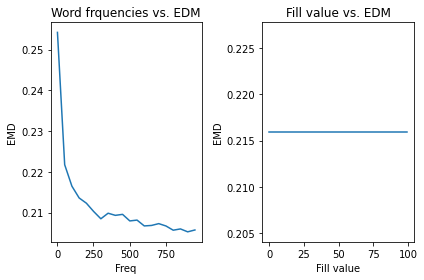

In [15]:
plt.subplot(1, 2, 1)

plt.plot(list(r_1),emds_1)
plt.title("Word frquencies vs. EDM")
plt.ylabel("EMD")
plt.xlabel("Freq")

plt.subplot(1, 2, 2)
plt.plot(list(r_2),emds_2)
plt.title("Fill value vs. EDM")
plt.ylabel("EMD")
plt.xlabel("Fill value")

plt.tight_layout()
plt.show()

It seems that in very low frequencies the EDM may not be completely stable. However the fill values does not  seem to matter at all, as it should be. 

### Experiments with the meassure 
Here we experiment with the measure to make sure it captures what we want. First of the EMD should be caputre copera where the embeddings have similar means but where one distrubution is more spread out. so let us generate some gaussians with more and more variance see how it evolves. 

In [16]:
from scipy.stats import multivariate_normal

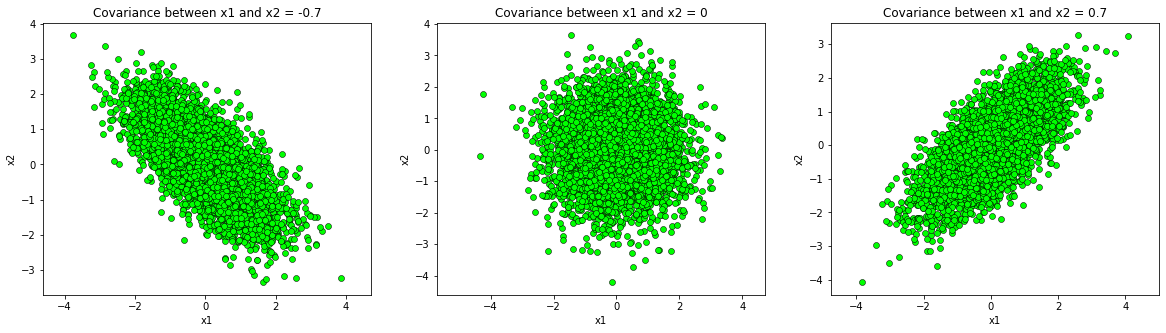

In [17]:
#inspiration from https://www.geeksforgeeks.org/visualizing-the-bivariate-gaussian-distribution-in-python/
plt.figure(figsize = (20,5))
for i, val in enumerate([-0.7,0,0.7]):    
    plt.subplot(1,3,i+1)
    cov = np.array([[1, val], [val, 1]])
    mean = np.array([0,0])

    # Generating a Gaussian bivariate distribution
    # with given mean and covariance matrix
    distr = multivariate_normal(cov = cov, mean = mean)

    # Generating 5000 samples out of the
    # distribution
    data = distr.rvs(size = 5000)

    # Plotting the generated samples
    plt.plot(data[:,0],data[:,1], 'o', c='lime',
             markeredgewidth = 0.5,
             markeredgecolor = 'black')
    plt.title(f'Covariance between x1 and x2 = {val}')
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.axis('equal')
plt.show()

comparison group

In [18]:
CompCov = 0.0
Distr = multivariate_normal(cov =  np.array([[1, CompCov], [CompCov, 1]]), mean = np.array([0,0]))
MultiNormComparison = Distr.rvs(size = 500)

In [19]:
MultiEdm = []
#CosDists = []

Covs = np.linspace(-0.99,0.99,100)

for i in tqdm(Covs):
    cov = np.array([[1, i], [i, 1]])
    mean = np.array([0,0])

    distr = multivariate_normal(cov = cov, mean = mean)

    data = distr.rvs(size = 500)
    
    #dm = cdist(data,MultiNormComparison,metric="cosine").sum() / 2
    #CosDists.append(dm)

    MultiEdm.append(word_emd(data,MultiNormComparison))

  0%|          | 0/100 [00:00<?, ?it/s]

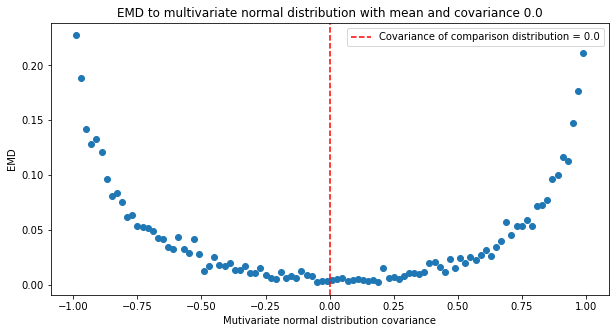

In [20]:
plt.figure(figsize = (10,5))
plt.scatter(Covs,MultiEdm)
plt.axvline(CompCov,label = "Covariance of comparison distribution = {}".format(CompCov), linestyle = "--", color = "red")
plt.xlabel("Mutivariate normal distribution covariance")
plt.ylabel("EMD")
plt.title("EMD to multivariate normal distribution with mean and covariance {}".format(CompCov))
plt.legend()
plt.show()

Now we generate a 2D Gaussian as comparison group, and then generate a number of 2D unvivatiate distributions, where we then transform a larger and larger share of to a normal deistribution with the same mean and cov (should be 0 as the distribution generated are independent - though this can be changes via "Choleski decomposition of the covariance matrix."), using the box muller transformation 

Begin by definng a box_muller funtion

In [21]:
CompCov = 0.0
Distr = multivariate_normal(cov =  np.array([[1, CompCov], [CompCov, 1]]), mean = np.array([0,0]))
MultiNormComparison = Distr.rvs(size = 1000)

In [40]:
def box_muller(size, share):
    #inspiration from: https://medium.com/mti-technology/how-to-generate-gaussian-samples-3951f2203ab0

    # 1. Generate 1000 U1 and U2, which are Unif(0, 1) 
    u1s, u2s = np.random.uniform(size=size), np.random.uniform(size=size)

    #transfomr a share of these into normal dist
    # 2. Tranform U1 to s
    ss = -np.log(u1s[:share])

    # 3. Transform U2 to theta
    thetas = 2*np.pi*u2s[:share]

    # 4. Convert s to r
    rs = np.sqrt(2*ss)

    # 5. Calculate x and y from r and theta
    xs, ys = rs*np.cos(thetas), rs*np.sin(thetas)

    xs = np.hstack((u1s[share:],xs))
    ys = np.hstack((u2s[share:],ys))
    data = np.vstack((xs,ys)).T
    
    return data

We then show how the distribution changes when transforming a larger share of the distribution into a 2D normal dist. The first image in Uniform, and the last is fulle Normal.

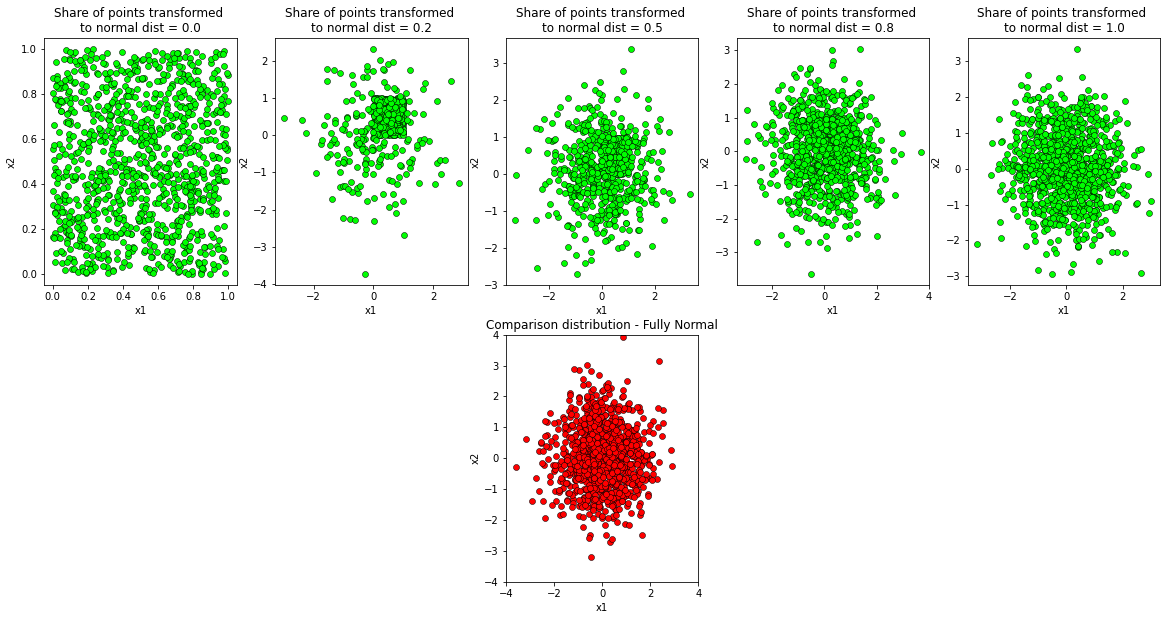

In [41]:
shares = [0,200,500,800,1000]
size = 1000

plt.figure(figsize = (20,10))


for i,share in enumerate(shares):
    data = box_muller(size,share)
    
    plt.subplot(2,len(shares),i+1)

    # Plotting the generated samples
    plt.plot(data[:,0],data[:,1], 'o', c='lime',
             markeredgewidth = 0.5,
             markeredgecolor = 'black')
    plt.title(f'Share of points transformed \nto normal dist = {share/size}')
    plt.xlabel('x1')
    plt.ylabel('x2')
    #plt.xlim(-4,4)
    #plt.ylim(-4,4)
    #plt.axis('equal')
    
#plot the comparison distribution 
plt.subplot(2,len(shares),len(shares) + int(np.ceil(len(shares)/2)))
plt.plot(MultiNormComparison[:,0],MultiNormComparison[:,1], 'o', c='red',
         markeredgewidth = 0.5,
         markeredgecolor = 'black')
plt.title(f'Comparison distribution - Fully Normal')
plt.xlabel('x1')
plt.ylabel('x2')
plt.xlim(-4,4)
plt.ylim(-4,4)
plt.show()


In [28]:
BmEmd = []
shares = range(0,1000,50)

for share in tqdm(shares):
    data = box_muller(1000,share)
    BmEmd.append(word_emd(data,MultiNormComparison))
    

  0%|          | 0/20 [00:00<?, ?it/s]

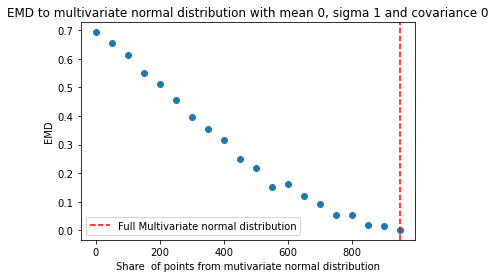

In [29]:
plt.scatter(shares,BmEmd)
plt.axvline(shares[-1],label = "Full Multivariate normal distribution", linestyle = "--", color = "red")
plt.xlabel("Share  of points from mutivariate normal distribution")
plt.ylabel("EMD")
plt.title("EMD to multivariate normal distribution with mean 0, sigma 1 and covariance 0")
plt.legend()
plt.show()

Thus the EDM calculated using the cosine distribution between the word embeddings, seem to capture the differences in distribution with we want to measures.